## Modules and utilities

In [1]:
from utilities import *
import numpy as np
import os
import re
import pandas as pd
from scipy import constants
from scipy import signal
from scipy import interpolate
from scipy import fft
import matplotlib.pyplot as plt
%matplotlib inline



In [4]:
def getforcefiles(dirpath):
    csv_list = []
    for root, dirs, files in os.walk(dirpath):
        for name in files:
            if name.endswith('txt'):
                filename = os.path.join(root, name)
                csv_list.append(filename)
    return csv_list

def importforces(path):
    df = pd.read_csv(path, sep='\t',header=None, names=colnames)
    df['FX_sum'] = df['FX_9504'] + df['FX_9505']
    df['FY_sum'] = df['FY_9504'] + df['FY_9505']
    df['FZ_sum'] = df['FZ_9504'] + df['FZ_9505']
    df['time']=df.index
    return df

def ezplot(df,which=None,save=False):
    fig, ax=plt.subplots( nrows=1, ncols=1 )
    if 'time' in df:
        df.plot.line(x='time',y='FX_sum', ax=ax, lw=0.5, color='red')
        df.plot.line(x='time',y='FY_sum', ax=ax, lw=0.5, color='green')
        df.plot.line(x='time',y='FZ_sum', ax=ax, lw=0.5, color='blue')
    else:
        df.reset_index().plot.line(x='ATI_time',y='FX_sum', ax=ax, lw=0.5, color='red')
        df.reset_index().plot.line(x='ATI_time',y='FY_sum', ax=ax, lw=0.5, color='green')
        df.reset_index().plot.line(x='ATI_time',y='FZ_sum', ax=ax, lw=0.5, color='blue')
    plt.show()
    if save==True:
        wd=os.path.dirname(which)
        title='plot_'+os.path.basename(which).split(".")[0]
        fig.savefig(fname=wd+'/'+title+'.png')
    plt.close(fig)
    return ax

## Import in vivo log

In [5]:
log_path = '/Users/phil/Desktop/rotoscoping/InVivoLog-jul18.csv'
csv_dir = '/Users/phil/Desktop/rotoscoping/forceplate'
colnames = ['FX_9504','FY_9504','FZ_9504','TX_9504','TY_9504','TZ_9504',
            'FX_9505','FY_9505','FZ_9505','TX_9505','TY_9505','TZ_9505']

log = pd.read_csv(log_path, index_col=0)

## Calculate plate resonant frequency
result: 142-150Hz

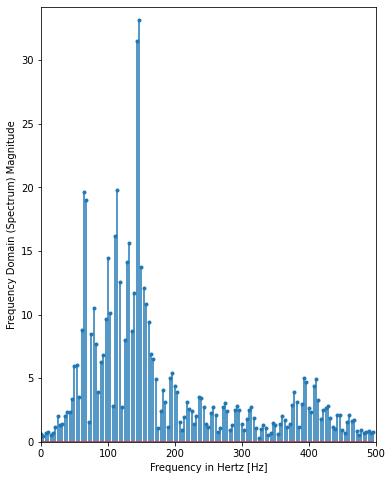

146.42857142857144


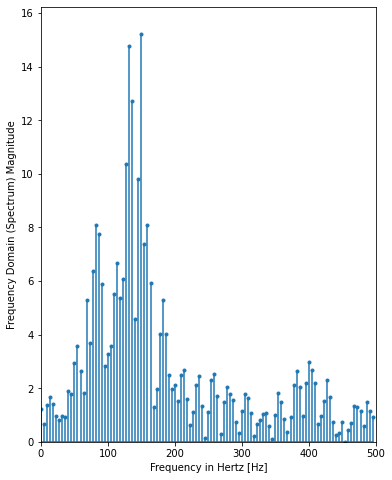

150.0


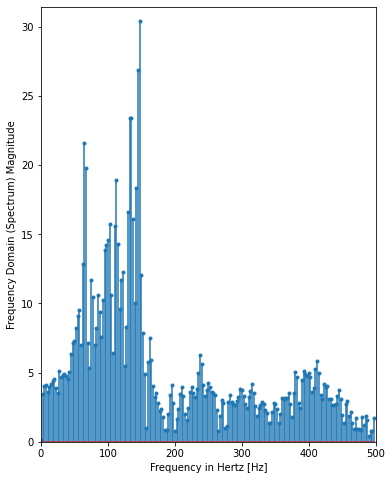

147.5


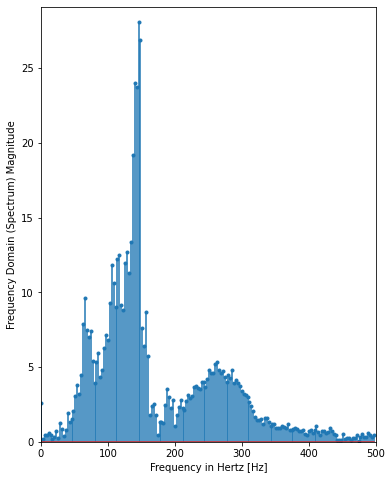

145.71428571428572


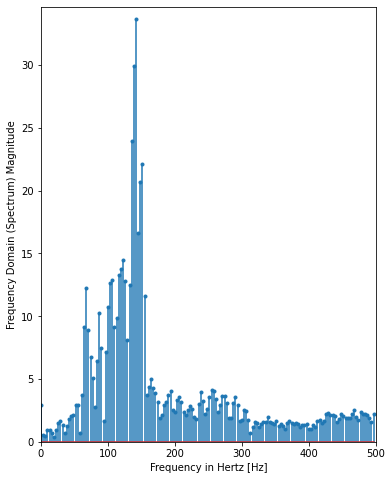

141.93548387096774


In [17]:
sampling_freq = 1000
test_path = '/Users/phil/Desktop/rotoscoping/forceplate/data-sep27-2019/outside_plate_tap_test.txt'
rf_df = importforces(test_path)
tap_one = rf_df.iloc[2120:2400]
tap_two = rf_df.iloc[2780:3000]
tap_three = rf_df.iloc[3400:3800]
tap_four = rf_df.iloc[11250:11600]
tap_five = rf_df.iloc[12190:12500]

def calc_fft(data, sampling_freq):
    X = fft.fft(np.array(data))
    freqs = fft.fftfreq(len(data))*sampling_freq
    fig, ax = plt.subplots(figsize=(6,8))
    ax.stem(freqs, np.abs(X),markerfmt='.')
    ax.set_xlabel('Frequency in Hertz [Hz]')
    ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
    ax.set_xlim(0, sampling_freq /2)
    ax.set_ylim(0, np.abs(X).max()+1)
    plt.show()
    return(freqs[np.abs(X).argmax()])

for tap in [tap_one,tap_two,tap_three,tap_four,tap_five]:
    freq = calc_fft(tap['FZ_sum'],sampling_freq)
    print(freq)

In [18]:
import numpy as np
resonants = [141.93548387096774,145.71428571428572,147.5
,150.0
,146.42857142857144
]
np.mean(resonants),np.std(resonants)

(146.31566820276498, 2.6282071993824223)

## Movement Hz

In [19]:
frame_duration = 1/125
footdown_toeoff = [[281,534],[215,529],[260,591],[206,590],[238,601],[178,342],[130,258],[172,254],[378,488],[71,159],[312,617],[294,561],[277,583],[170,315],[295,430],[267,324]]
stance_durations = [arr[1]-arr[0] for arr in footdown_toeoff]
stance_durations_s = [dur*frame_duration for dur in stance_durations]
stride_period_s = [dur*2 for dur in stance_durations_s]
stride_frequency_s = [1/prd for prd in stride_period_s]
np.mean(np.array(stride_frequency_s)), np.std(np.array(stride_frequency_s))

(0.4070974456258528, 0.259030865109973)

## Grab GRF data

In [6]:
csv_list = getforcefiles(csv_dir)
csv_dict = {
    '21_t2_fullstride_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct7-2019/21.txt',
    '20_t3_fullstride_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct7-2019/20.txt',
    '12_t1_fullstride_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct7-2019/12.txt',
    '23_t3_fullstride_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct7-2019/23.txt',
    '9_t4_fullstride_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct7-2019/9.txt',
    '9_p3_fullstride_A-':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct9-2019/9.txt',
    '14_p1_fullstride_A-':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct9-2019/14.txt',
    '3_p2_fullstride_a-':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct14-2019/3.txt',
    '8_p4_fullstride_a':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct14-2019/8.txt',
    '9_p2_squeeze_A+':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct16-2019/9.txt',
    '6_t1_squeeze_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct16-2019/6.txt',
    '1_t2_squeeze_A-':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct23-2019/1.txt',
    '2_t2_squeeze_A-':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct23-2019/2.txt',
    '5_t1_squeeze_A+':'/Users/phil/Desktop/rotoscoping/forceplate/data-nov1-2019/5.txt',
    '6_t4_squeeze_A-':'/Users/phil/Desktop/rotoscoping/forceplate/data-nov1-2019/6.txt',
    '3_p4_squeezelow_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-nov6-2019/3.txt',
    '9_p3_squeezelow_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-nov6-2019/9.txt',
    '12_p1_squeezelow_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-nov6-2019/12.txt',
    '2_p3_stand':'/Users/phil/Desktop/rotoscoping/forceplate/data-feb3-2020/2.txt',
    '3_p1_stand':'/Users/phil/Desktop/rotoscoping/forceplate/data-feb3-2020/3.txt',
    '11_t1_stand':'/Users/phil/Desktop/rotoscoping/forceplate/data-feb3-2020/11.txt',
    '12_t2_stand':'/Users/phil/Desktop/rotoscoping/forceplate/data-feb3-2020/12.txt',
    '13_t2_stand':'/Users/phil/Desktop/rotoscoping/forceplate/data-feb3-2020/13.txt',
}
for trial in csv_dict.keys():
    csv_dict[trial] = importforces(csv_dict[trial]).drop(['time'],axis=1)
force_df = pd.concat(csv_dict, names=['Run ID','ATI_time'])

## Find sync peaks

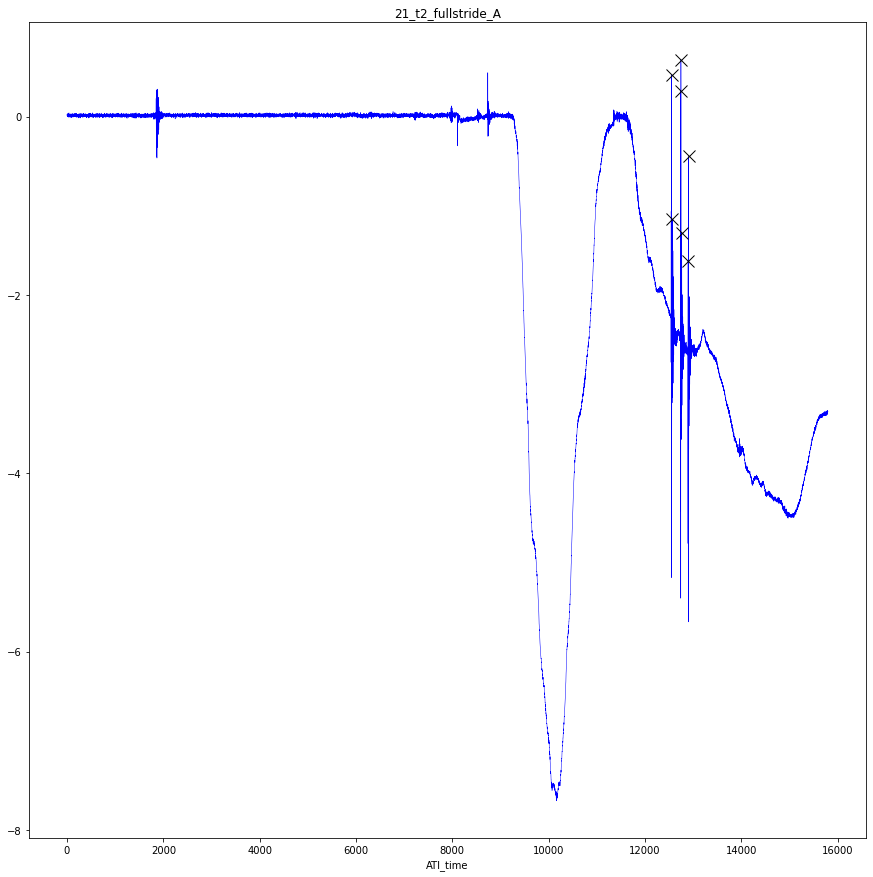

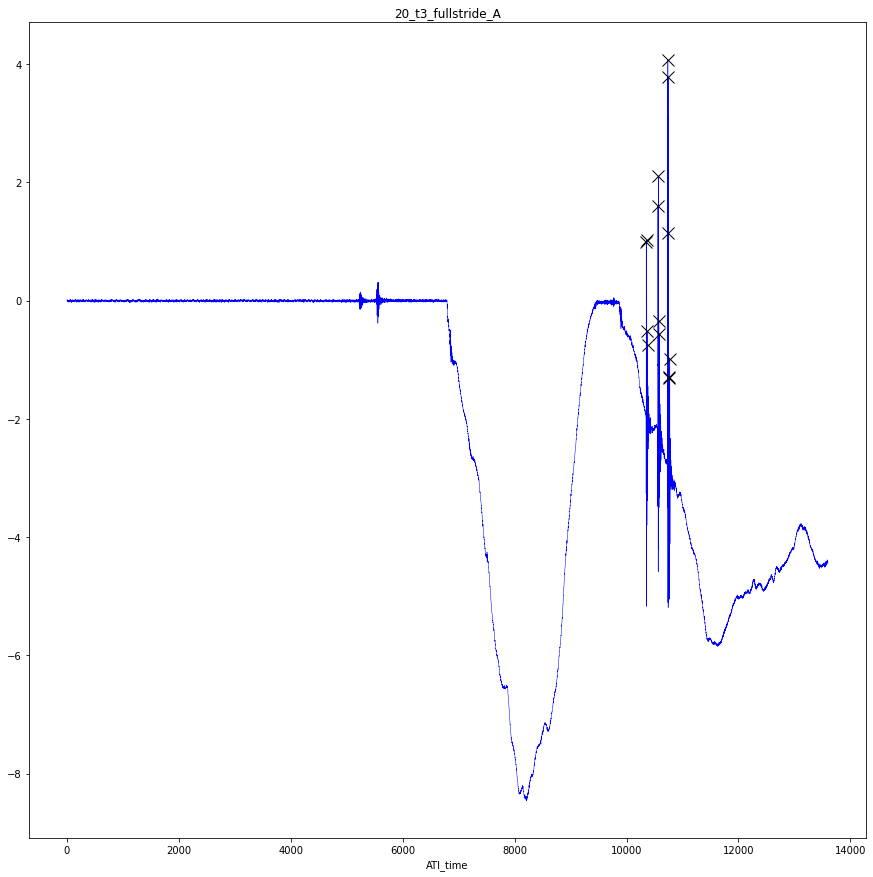

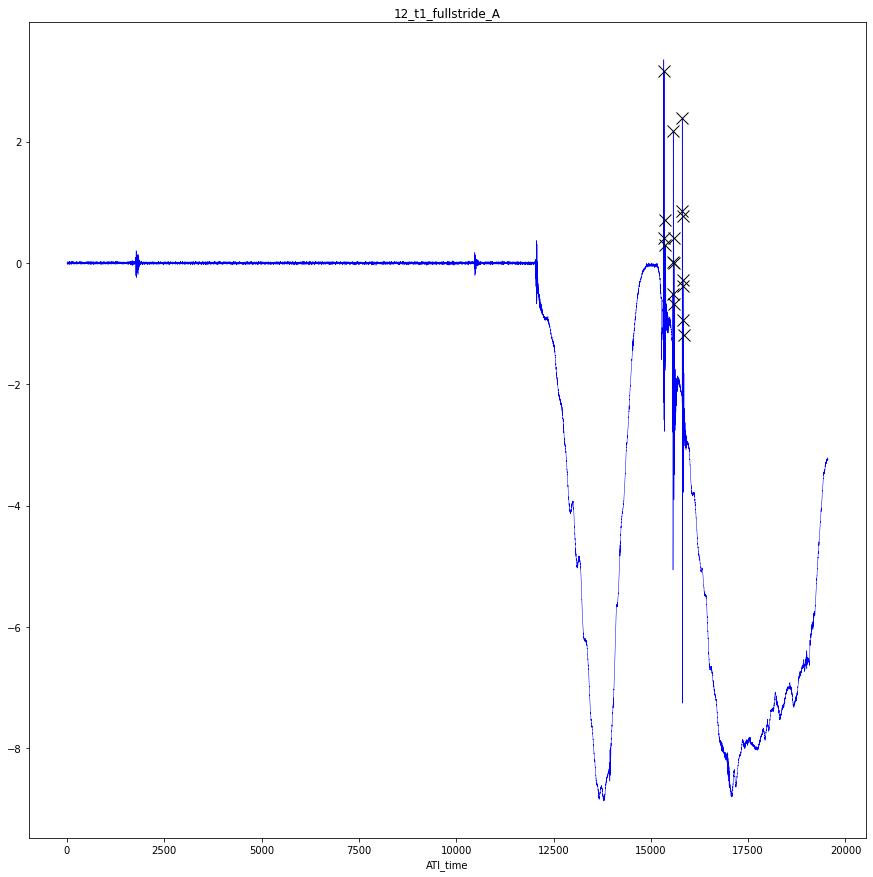

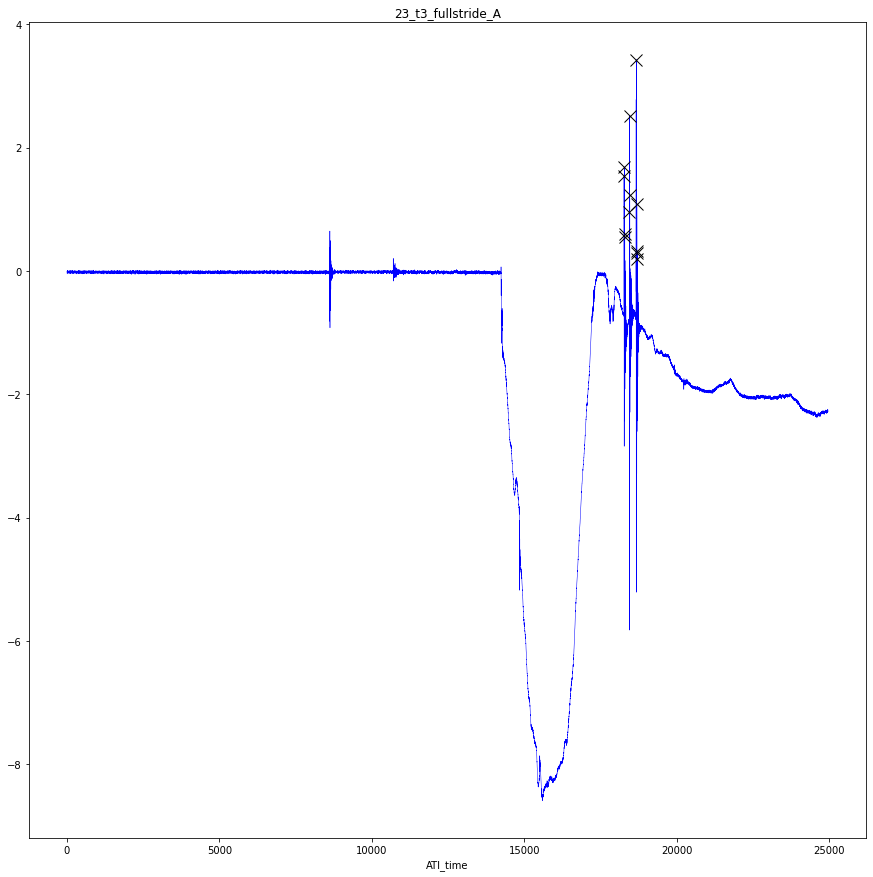

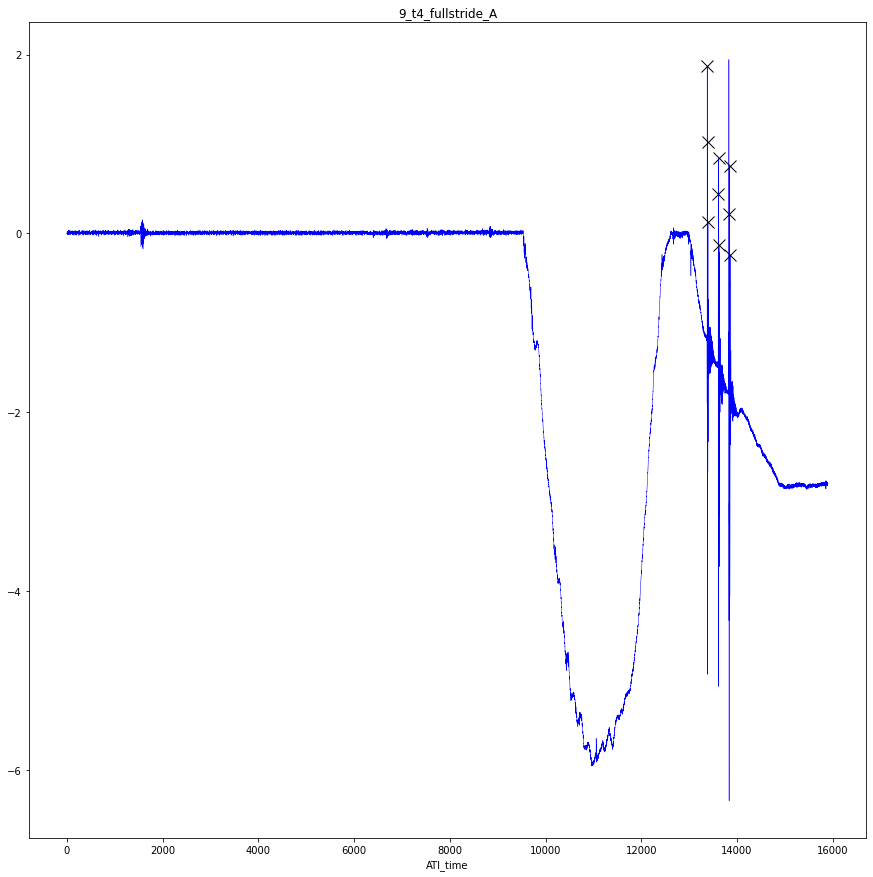

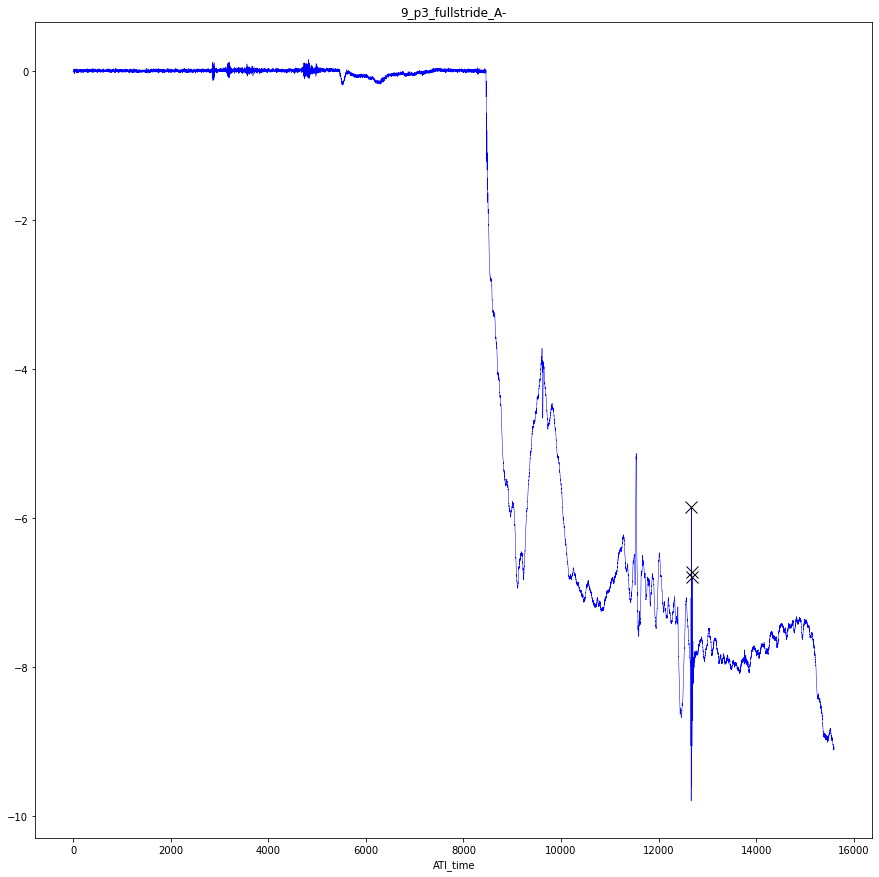

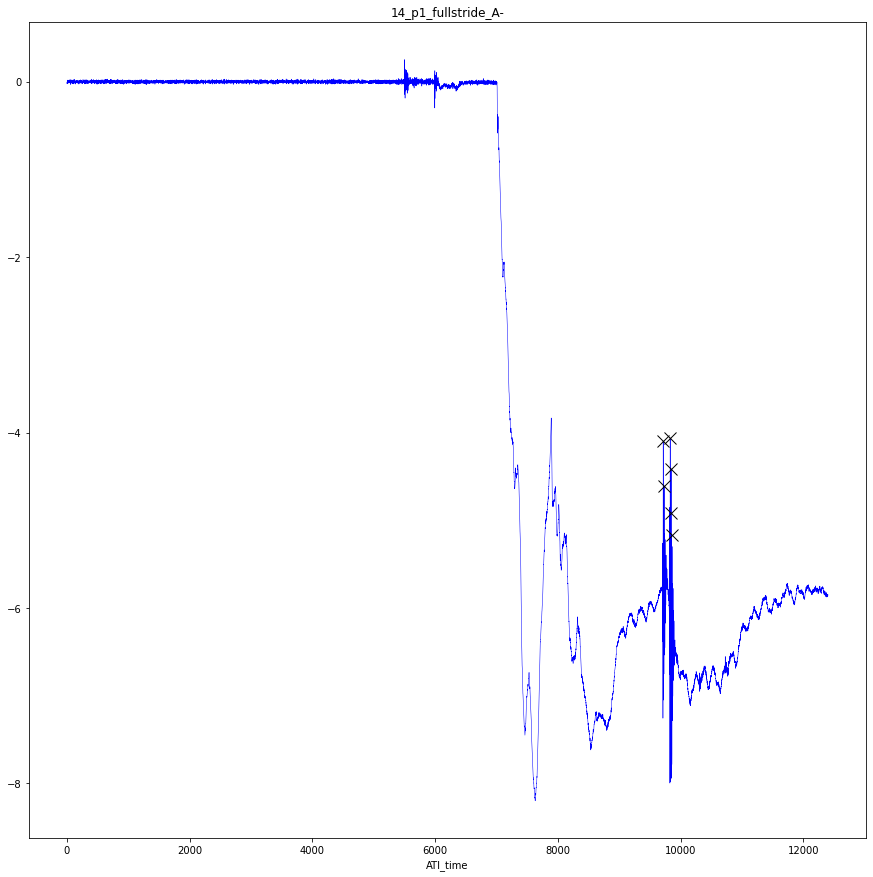

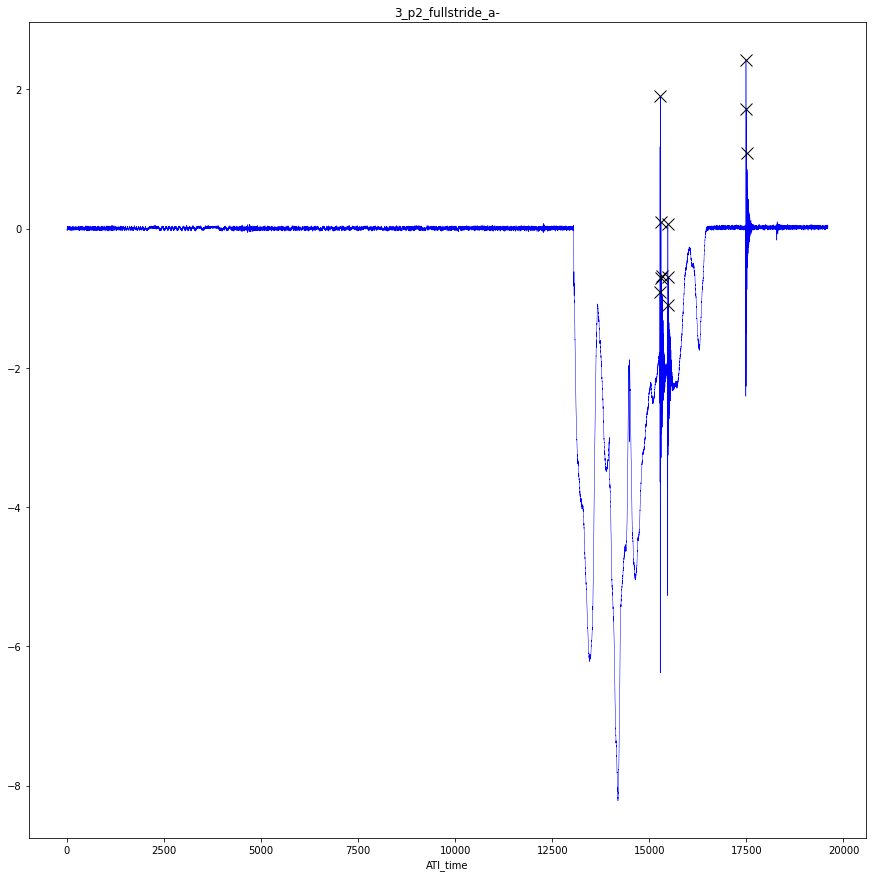

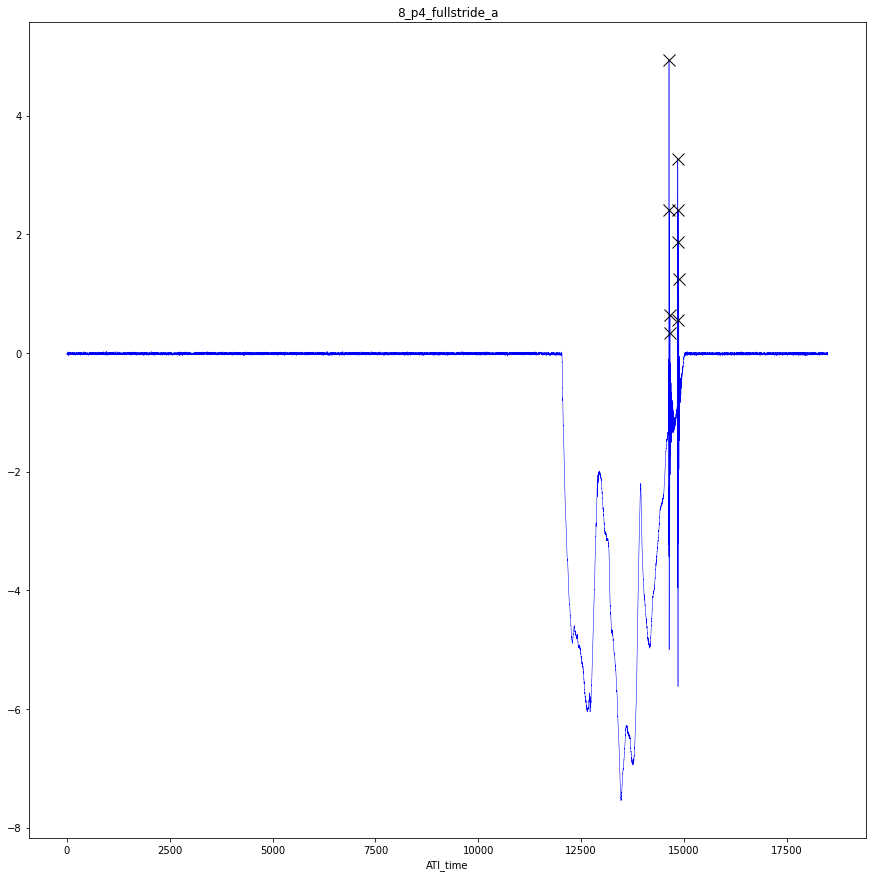

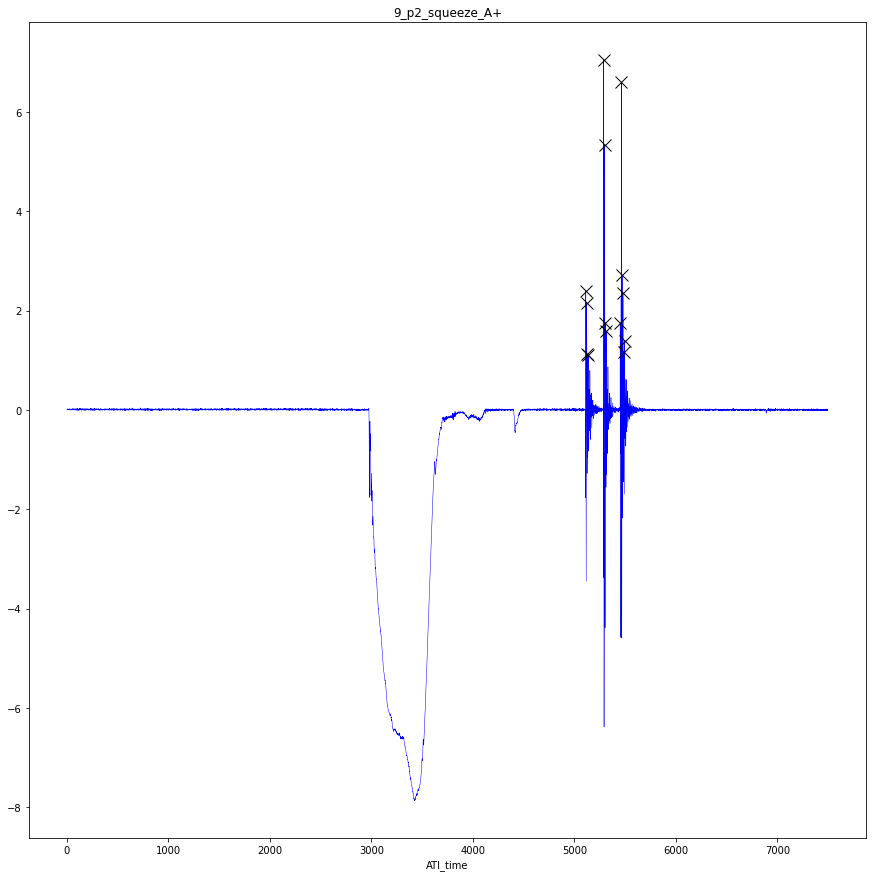

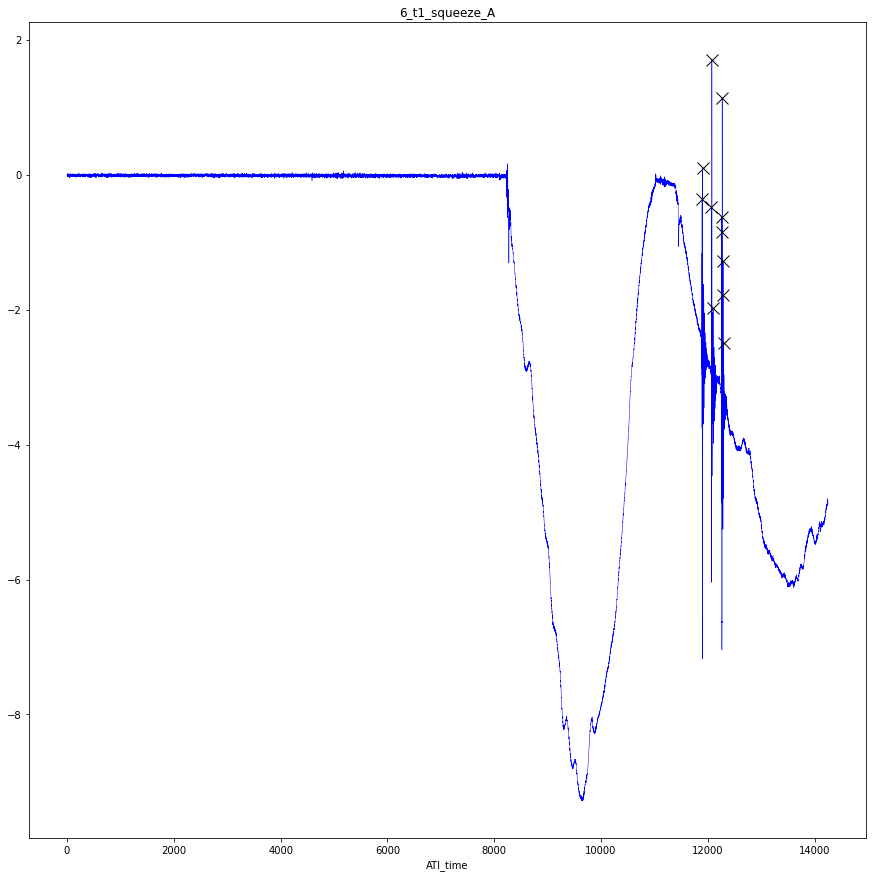

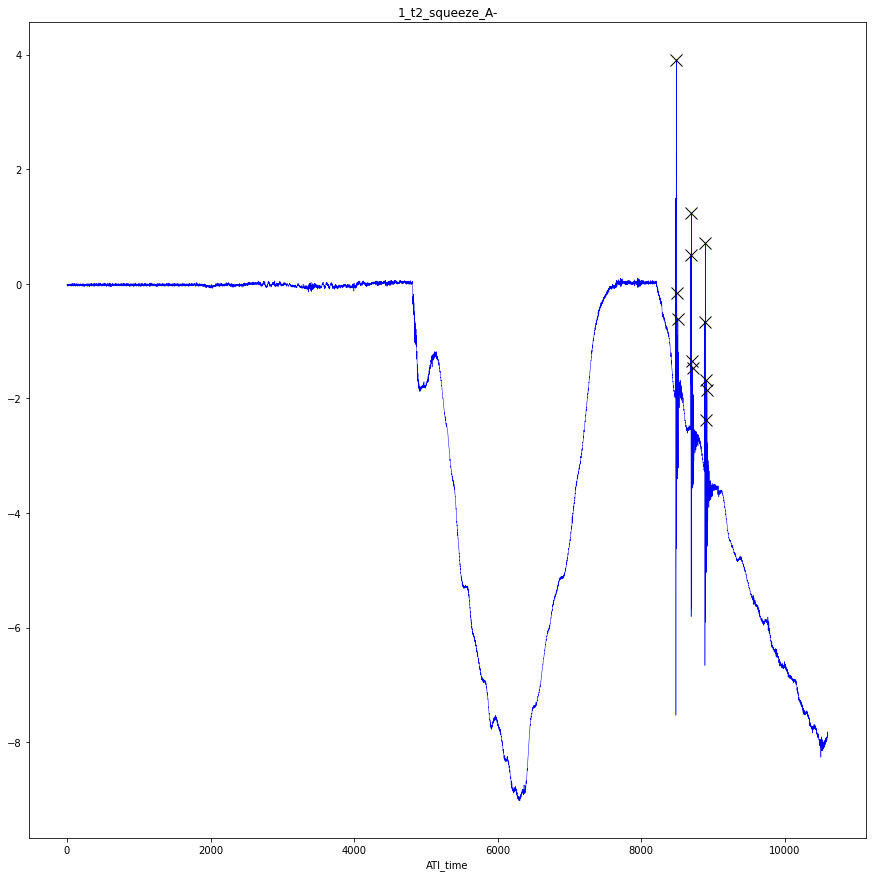

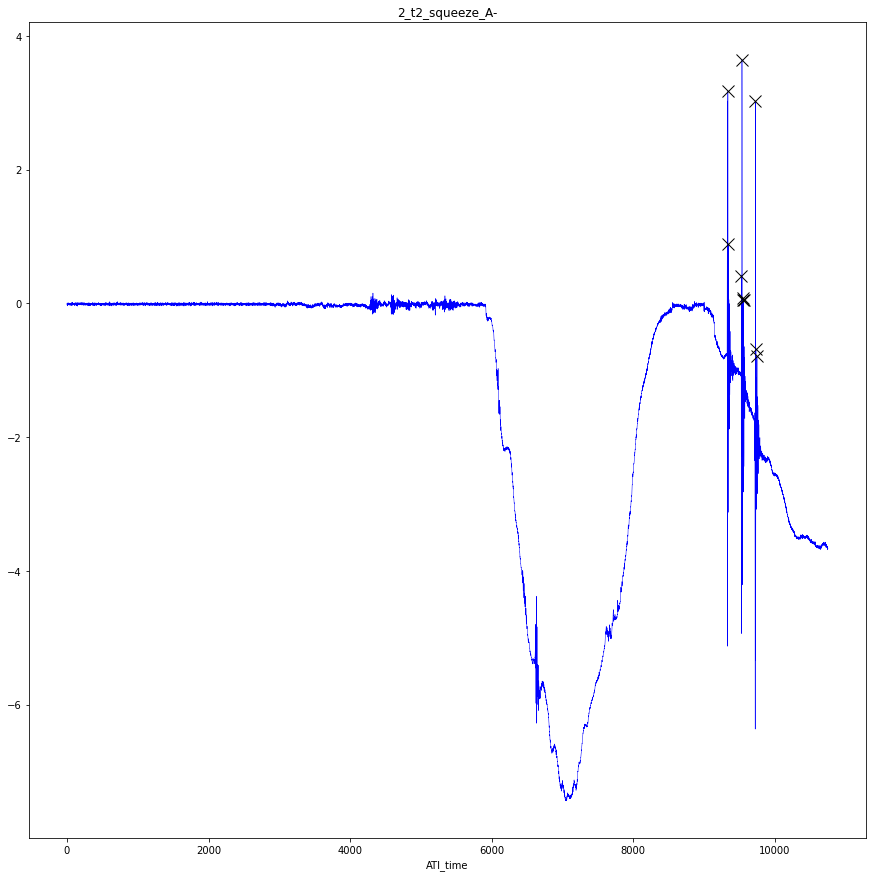

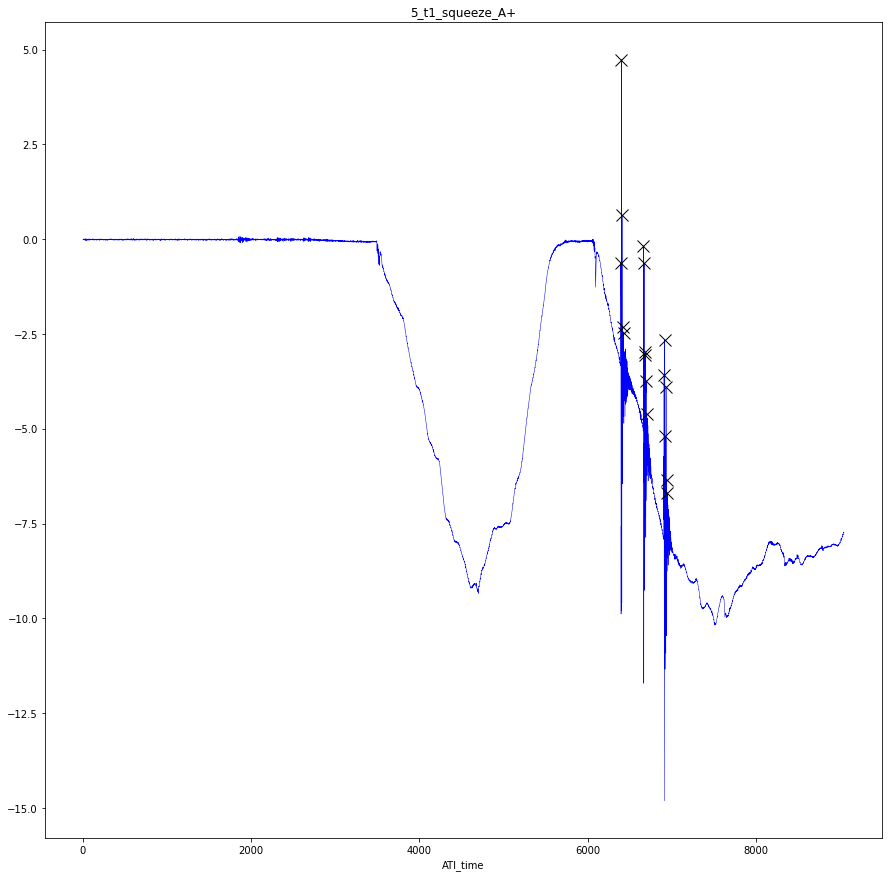

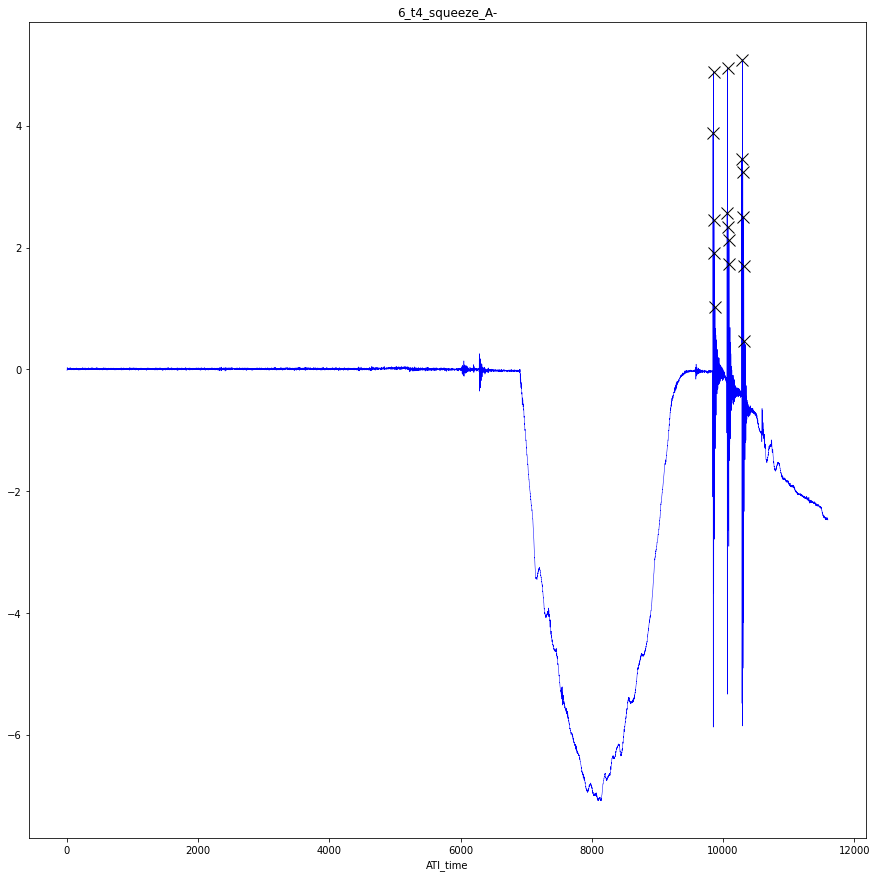

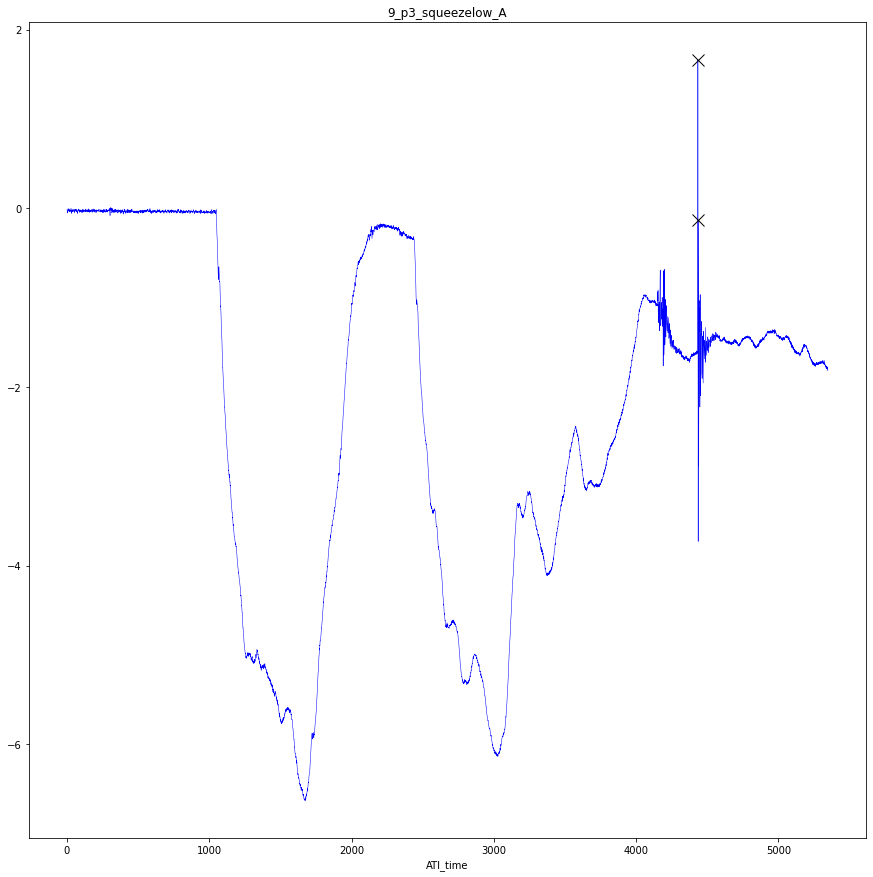

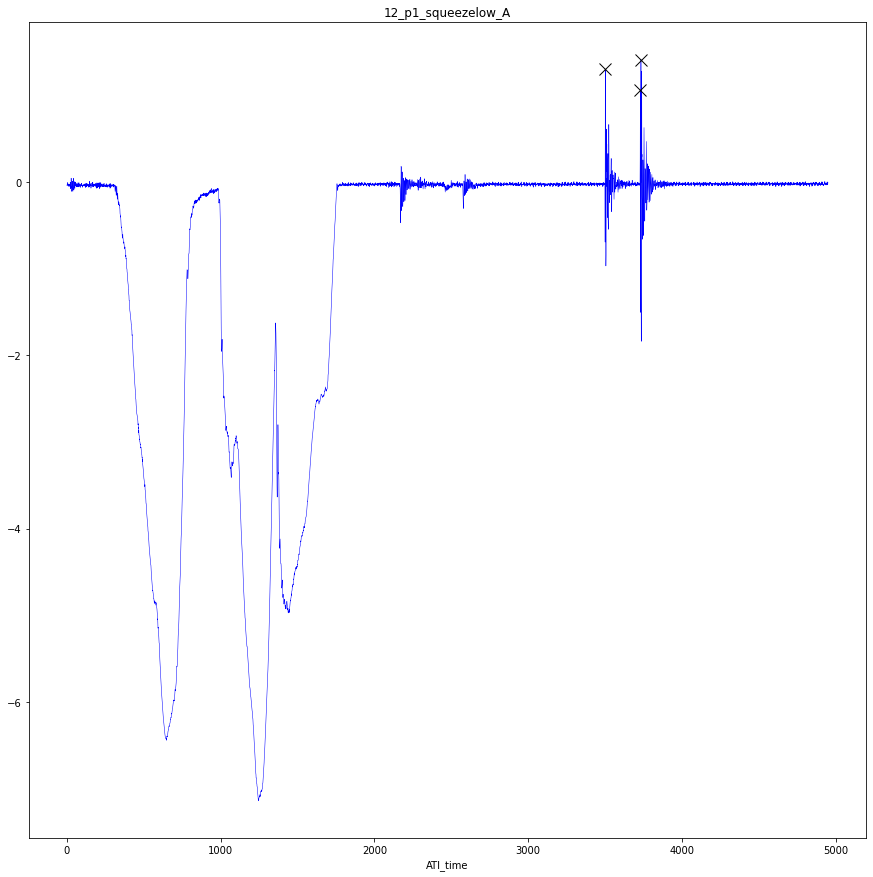

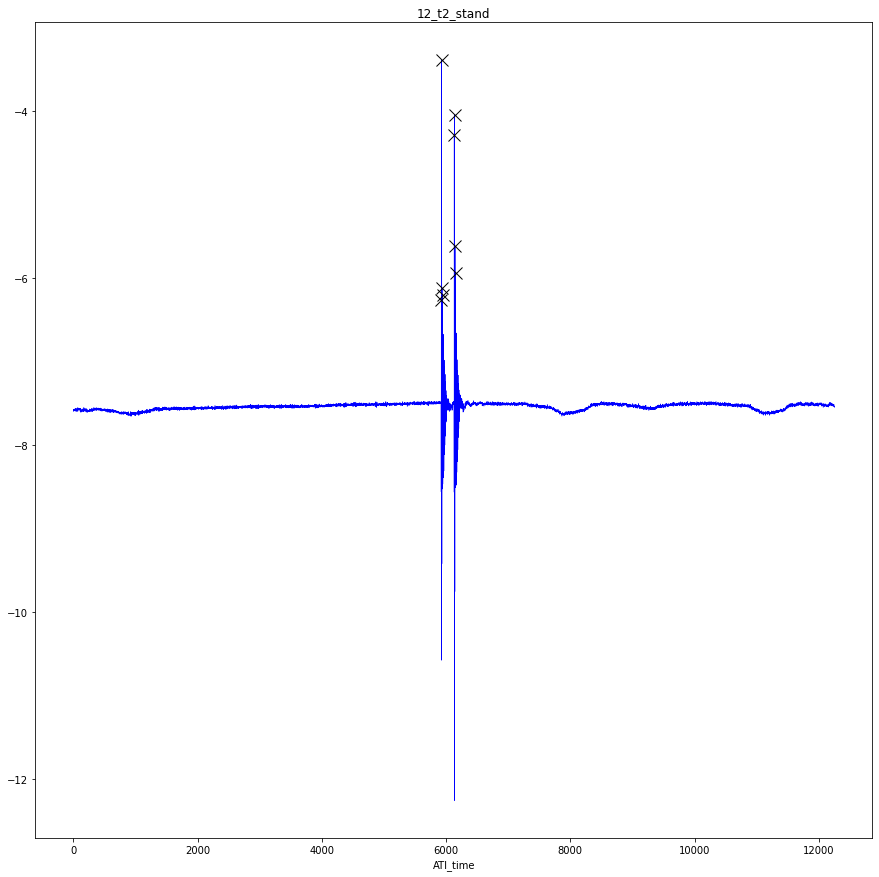

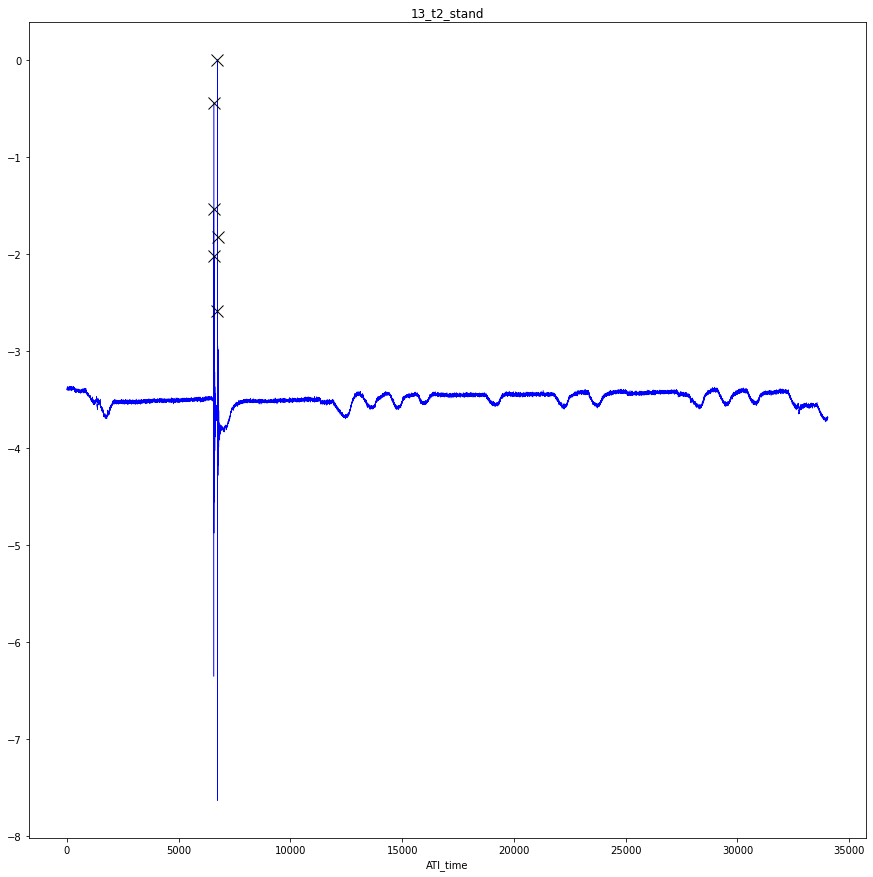

In [7]:
skip_crop = ['3_p4_squeezelow_A', '2_p3_stand','3_p1_stand', '11_t1_stand']
for trial_id in csv_dict.keys():
    if not trial_id in skip_crop:
        zData = force_df.loc[trial_id,'FZ_sum']
        peaks, _ = signal.find_peaks(zData, prominence=2, distance=1, width=(1,10))
        log.loc[trial_id,'force_sync'] = peaks[0]
        fig, ax=plt.subplots( figsize=(15,15) )
        zData.plot.line(x='time',y='FZ_sum', ax=ax, lw=0.5, color='blue')
        ax.plot(peaks, zData[peaks],"x", markersize=12, color="black")
        ax.set_title(trial_id)
        plt.show()

## Normalize by BW

In [8]:
norm_force_df = force_df.copy()
for trial in csv_dict.keys():
    norm_force_df.loc[pd.IndexSlice[trial,:],:]/=(log.loc[trial,'Mass (kg)']*constants.g)

## low-pass butterworth filter

#### choose filter cutoff

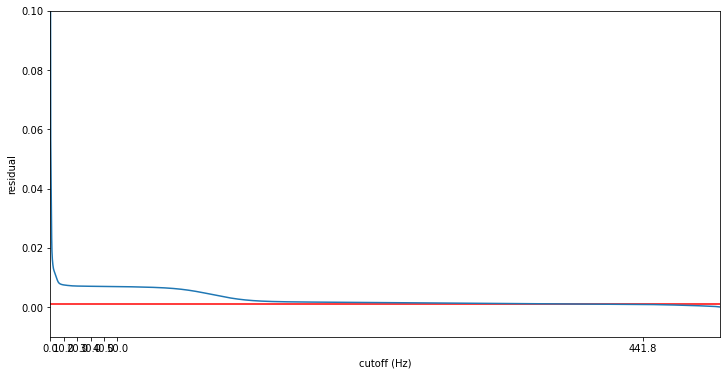

In [56]:
# test_trial = '21_t2_fullstride_A'
test_trial = '14_p1_fullstride_A-'

sampling_f = log.loc[test_trial,'ATI sampling (Hz)']
test_range = np.arange(0.1, 499.1, 0.1)
test_trial = norm_force_df.loc[test_trial,'FZ_sum']
baseline = test_trial[0:1000]

def find_noise(baseline):
    rms = np.sqrt(np.mean(baseline**2))
    return rms

def make_butter(data, cutoff, sampling_f):
    b, a = signal.butter(4, cutoff, btype='lowpass', fs=sampling_f)
    y = signal.filtfilt(b, a, data)
    return y

def get_residual(data, cutoff, sampling_f):
    ys = make_butter(data, cutoff, sampling_f)
    residual = math.sqrt(np.mean((data-ys)**2))
    return residual

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

noise_floor = find_noise(baseline)
residuals = [get_residual(test_trial, cutoff, sampling_f) for cutoff in test_range]
critical_residual, cf_idx = find_nearest(residuals, noise_floor)
opt_cutoff = test_range[cf_idx]

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(test_range, residuals)
ax.hlines(noise_floor, 0, test_range.max(), colors='red')
# ax.vlines(opt_cutoff, -0.01, noise_floor, colors='orange')
ax.set_ylim([-0.01, 0.1])
ax.set_xlim([0, test_range.max()])
ax.set_ylabel('residual')
ax.set_xlabel('cutoff (Hz)')
ax.set_xticks([0,opt_cutoff,10,20,30,40,50])

In [10]:
fs = 1000


def find_noise(baseline):
    rms = np.sqrt(np.mean(baseline**2))
    return rms

def make_butter(data, cutoff, sampling_f):
    b, a = signal.butter(4, cutoff, btype='lowpass', fs=sampling_f)
    y = signal.filtfilt(b, a, data)
    return y

def get_residual(data, cutoff, sampling_f):
    ys = make_butter(data, cutoff, sampling_f)
    residual = math.sqrt(np.mean((data-ys)**2))
    return residual

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx
def yuEtAl1999_find_opt_cutoff(df, fs):
    eq9 = 0.071*fs - 0.00003*(fs**2)
    filt_df = df.copy()
    filt_df.loc[:,'FX_sum']= make_butter(filt_df.loc[:,'FX_sum'], eq9, 1000)
    filt_df.loc[:,'FY_sum']= make_butter(filt_df.loc[:,'FY_sum'], eq9, 1000)
    filt_df.loc[:,'FZ_sum']= make_butter(filt_df.loc[:,'FZ_sum'], eq9, 1000)
    xn = df.loc[:,'FX_sum']
    xnfilt = filt_df.loc[:,'FX_sum']
    yn = df.loc[:,'FY_sum']
    ynfilt = filt_df.loc[:,'FY_sum']
    zn = df.loc[:,'FZ_sum']
    znfilt = filt_df.loc[:,'FZ_sum']    
    eq7x = math.sqrt(((xn-xnfilt)**2).sum()/((xn-xn.mean())**2).sum()*100)
    eq7y = math.sqrt(((yn-ynfilt)**2).sum()/((yn-yn.mean())**2).sum()*100)
    eq7z = math.sqrt(((zn-znfilt)**2).sum()/((zn-zn.mean())**2).sum()*100)    
    eq10x = 0.06*fs - 0.000022*(fs**2)+(5.95/eq7x)
    eq10y = 0.06*fs - 0.000022*(fs**2)+(5.95/eq7y)
    eq10z = 0.06*fs - 0.000022*(fs**2)+(5.95/eq7z)
    return(np.mean([eq10x, eq10y, eq10z]))
optima = [yuEtAl1999_find_opt_cutoff(norm_force_df.loc[trial], fs) for trial in norm_force_df.index.levels[0]]
np.mean(optima)

44.05412224083316

#### apply filter

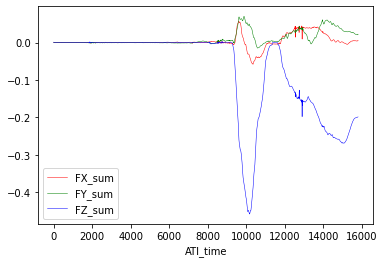

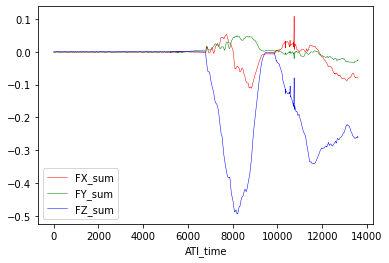

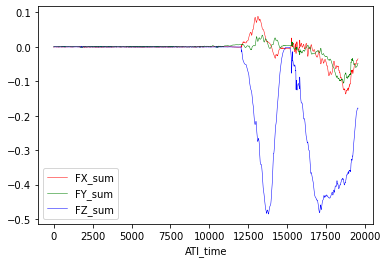

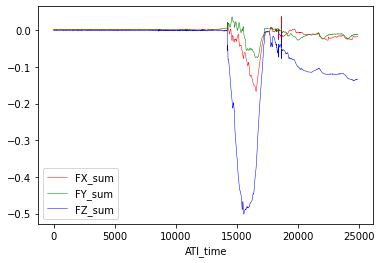

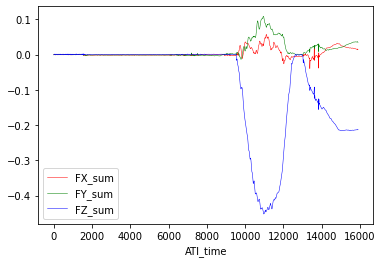

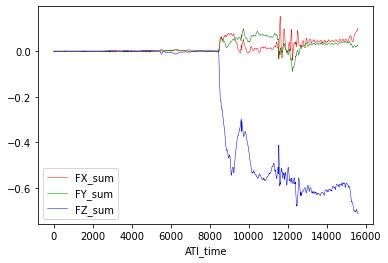

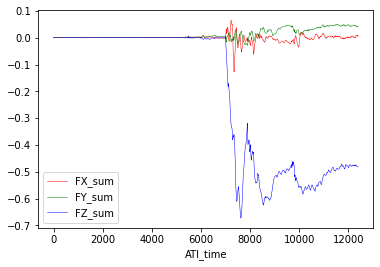

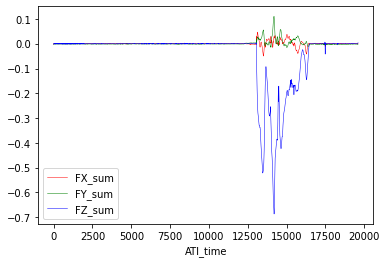

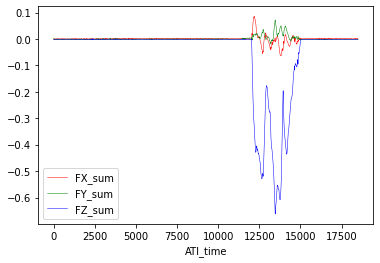

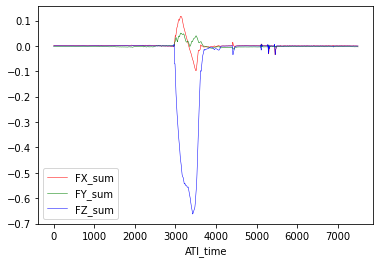

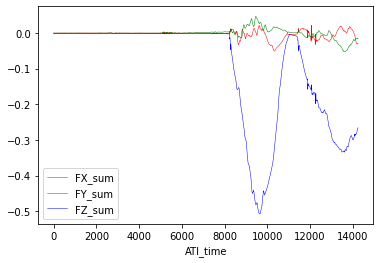

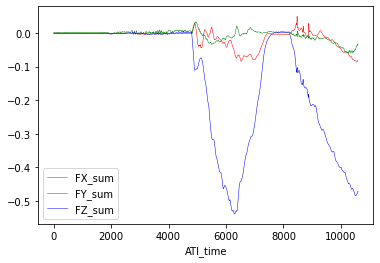

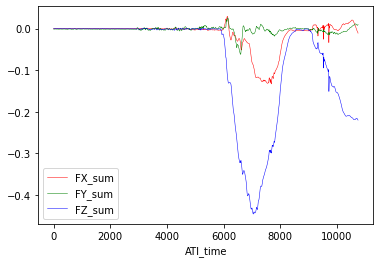

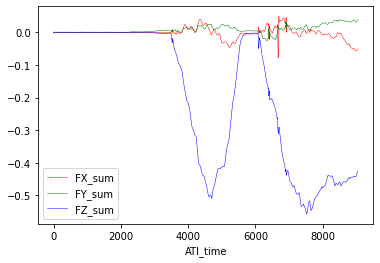

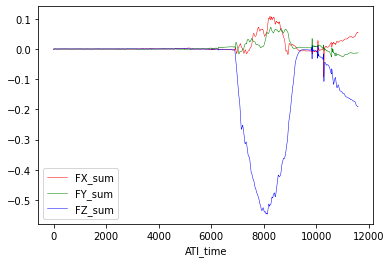

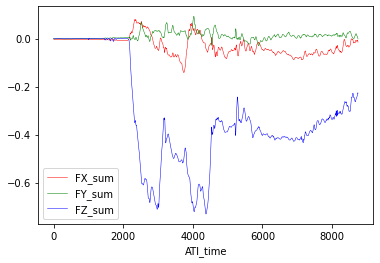

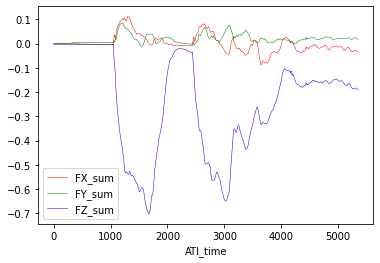

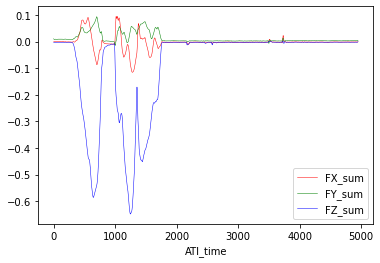

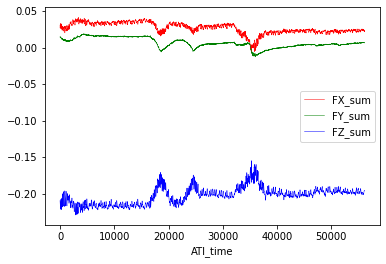

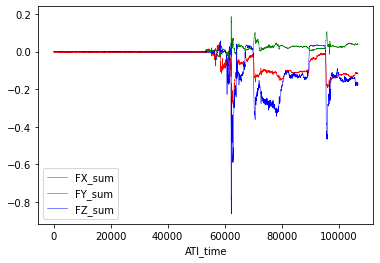

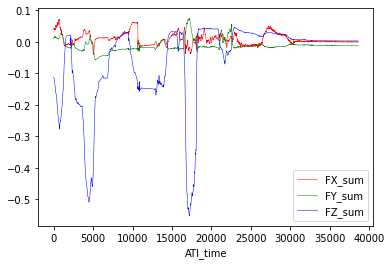

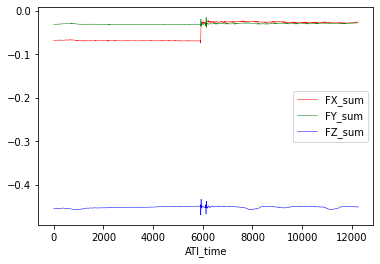

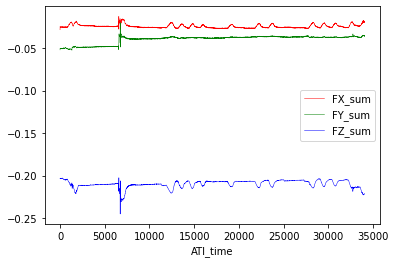

In [17]:
opt_cutoff = np.mean(optima)
filt_norm_force_df = norm_force_df.copy()
for trial_id in csv_dict.keys():
    sampling_f = log.loc[trial_id,'ATI sampling (Hz)']
    filt_norm_force_df.loc[trial_id,'FX_sum'] = make_butter(filt_norm_force_df.loc[trial_id,'FX_sum'], opt_cutoff, sampling_f)
    filt_norm_force_df.loc[trial_id,'FY_sum'] = make_butter(filt_norm_force_df.loc[trial_id,'FY_sum'], opt_cutoff, sampling_f)
    filt_norm_force_df.loc[trial_id,'FZ_sum'] = make_butter(filt_norm_force_df.loc[trial_id,'FZ_sum'], opt_cutoff, sampling_f)
    ezplot(filt_norm_force_df.loc[trial_id])
    
    

## April 27 revision:
found out one of the load cells was reporting flipped X values. Verified not a hardware issue from sep18 calibrations (x-axis pulley load). Wrong in sep26 data: must have changed something in DAC script. Flip X data from 9505 moving forward

<AxesSubplot:>

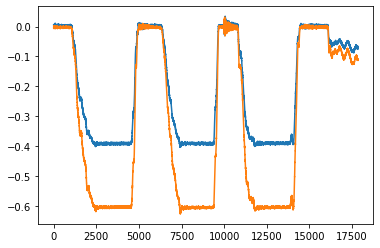

In [318]:
xpulley = importforces("/Users/phil/Desktop/rotoscoping/forceplate/forceplate-calibration-sep18-2019/x-pulley.txt")
xpulley /= (constants.g*.5)
xpulley.loc[:,'FX_9504'].plot()
xpulley.loc[:,'FX_9505'].plot()
# xpulley.loc[:,'FX_sum'].plot()


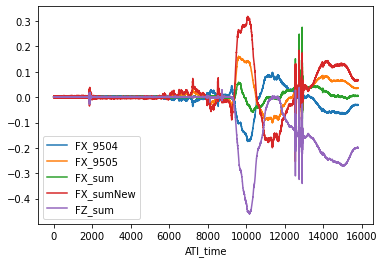

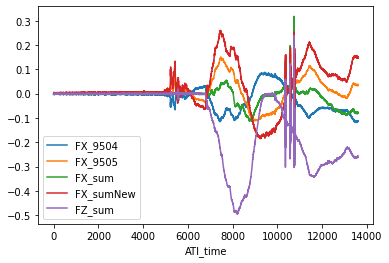

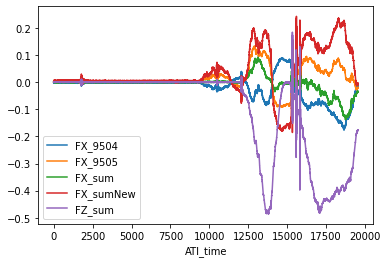

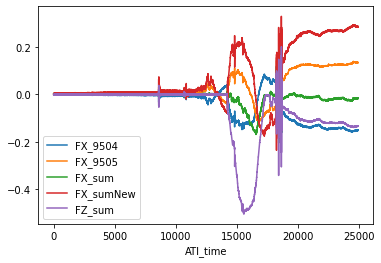

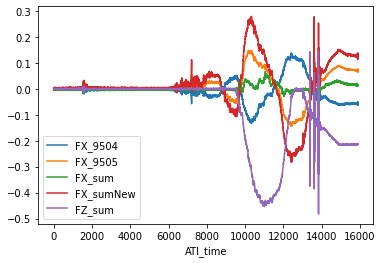

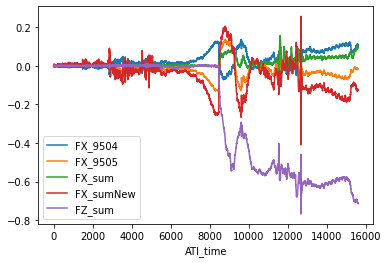

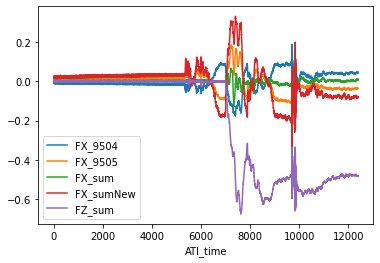

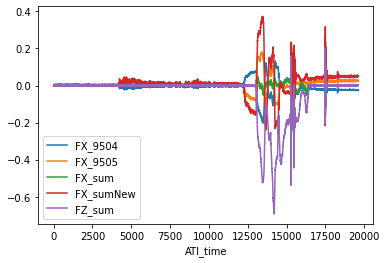

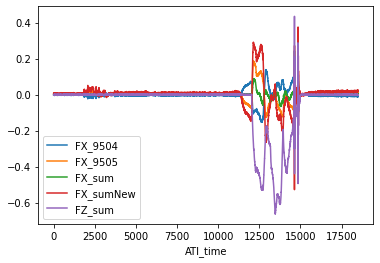

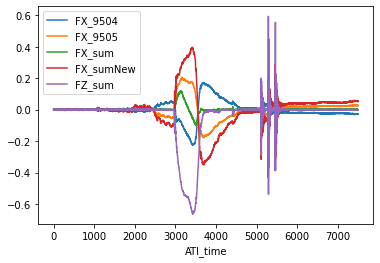

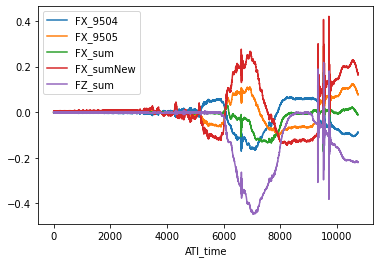

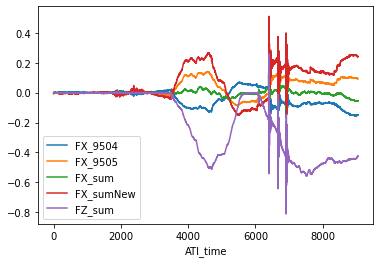

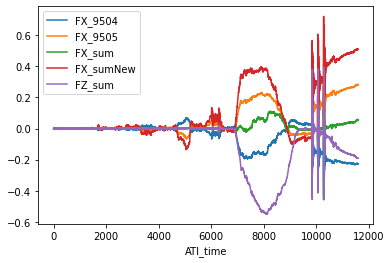

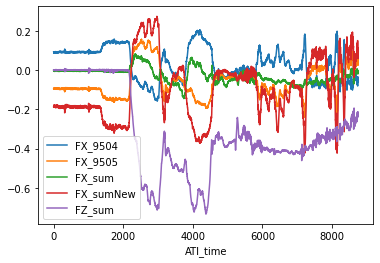

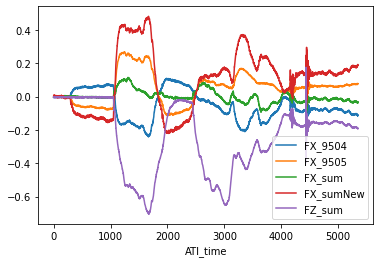

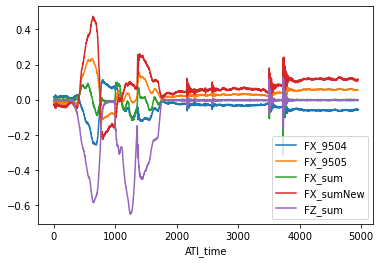

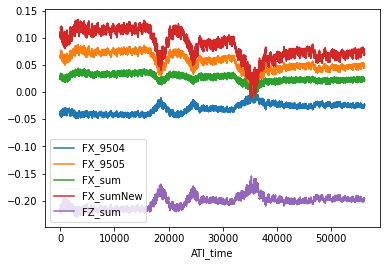

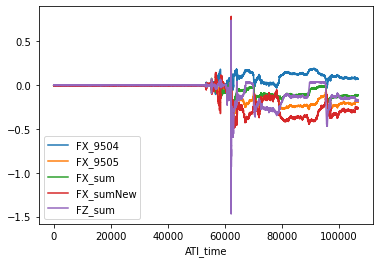

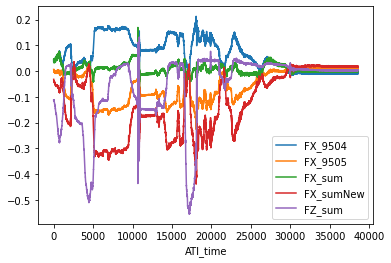

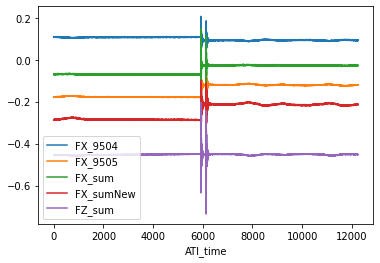

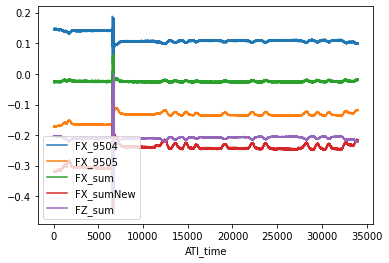

In [331]:
for trial in csv_dict.keys():
    testdf = norm_force_df.loc[trial]
    testdf['FX_9504'].plot(legend="true")
    testdf['FX_9505'].plot(legend="true")
    testdf['FX_sum'].plot(legend="true")
    testdf['FX_sumNew'] = testdf['FX_9505'] + (testdf['FX_9504']*-1)
    testdf['FX_sumNew'].plot(legend="true")
#     testdf['FZ_9504'].plot(legend="true")
#     testdf['FZ_9505'].plot(legend="true")
    testdf['FZ_sum'].plot(legend="true")


    plt.show()

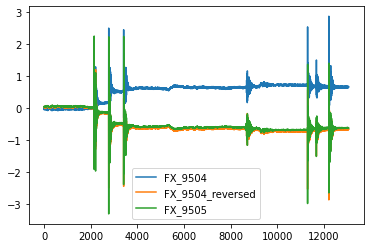

In [322]:
rf_df
rf_df['FX_9504'].plot(legend="true")
rf_df['FX_9504_reversed'] = rf_df['FX_9504']*-1
rf_df['FX_9504_reversed'].plot(legend="true")
# test = rf_df['FX_9504']+rf_df['FX_9504_reversed']
# test.plot()
rf_df['FX_9505'].plot(legend="true")
# rf_df['FX_sum'].plot(legend="true")
rf_df['FX_sum_new'] = rf_df['FX_9504']+ rf_df['FX_9505']
# rf_df['FX_sum_new'].plot(legend="true")

# rf_df['FX_sumNew'] = rf_df['FX_9505'] + (rf_df['FX_9504']*-1)
# rf_df['FX_sumNew'].plot(legend="true")
plt.show()

In [740]:
# deprecated...quintic spline interpolation following gosnell
# forces_interp = forces_bwNorm.copy()
# smoothing_param = 20
# splX = interpolate.UnivariateSpline(forces_interp['time'], forces_interp['FX_sum'], k=5, s=smoothing_param)
# splY = interpolate.UnivariateSpline(forces_interp['time'], forces_interp['FY_sum'], k=5, s=smoothing_param)
# splZ = interpolate.UnivariateSpline(forces_interp['time'], forces_interp['FZ_sum'], k=5, s=smoothing_param)
# xs = np.linspace(0, len(forces_interp), len(forces_interp))

# forces_interp['FX_sum'] = splX(xs)
# forces_interp['FY_sum'] = splY(xs)
# forces_interp['FZ_sum'] = splZ(xs)

## Crop force data to first tap

In [18]:
cropped_force_df = filt_norm_force_df.copy()
for trial_id in csv_dict.keys():
    sync_time = log.loc[trial_id,'force_sync']
    if not np.isnan(sync_time):
        sync_time_int = math.floor(sync_time)
        cropped_force_df.drop(cropped_force_df.loc[(trial_id,sync_time_int):(trial_id,)].index, inplace=True)

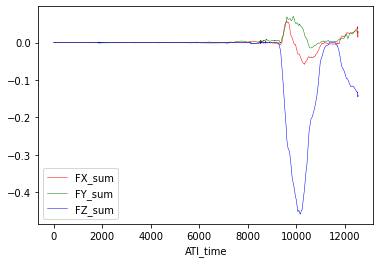

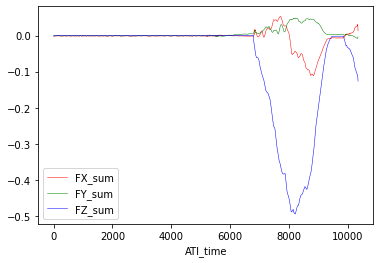

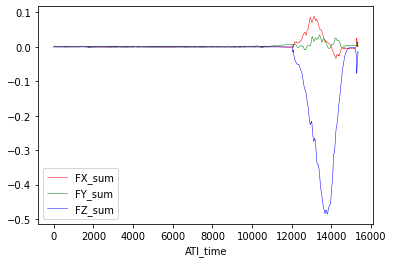

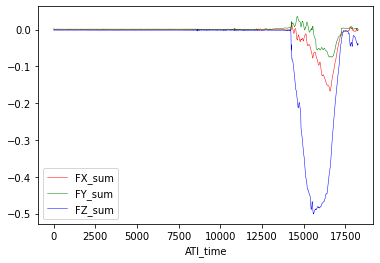

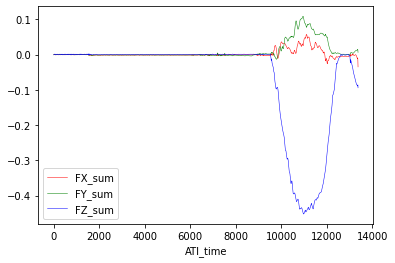

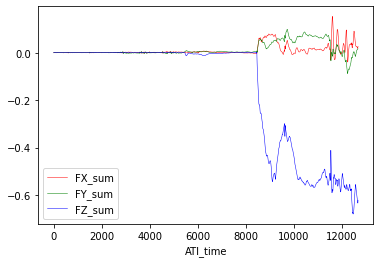

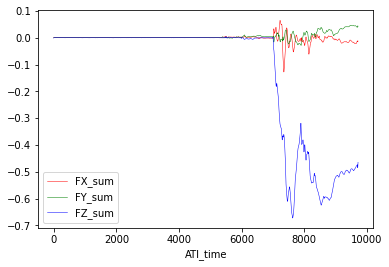

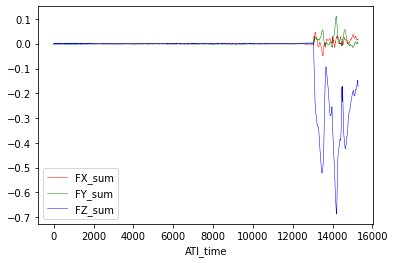

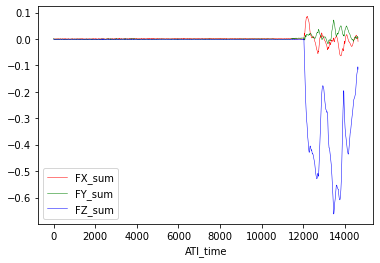

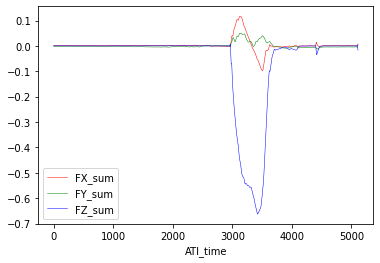

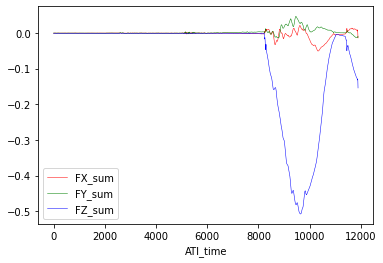

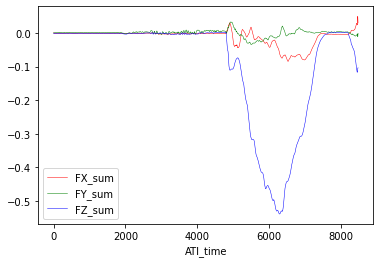

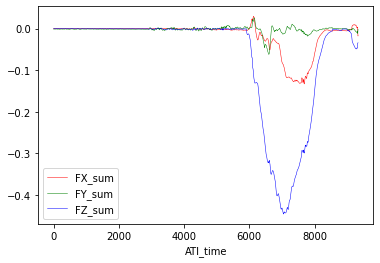

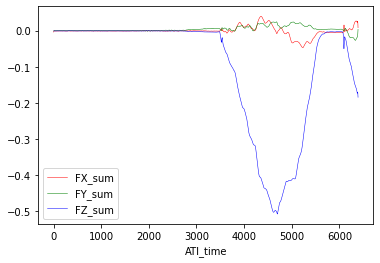

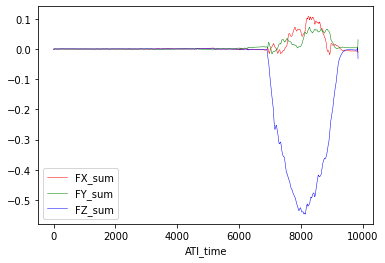

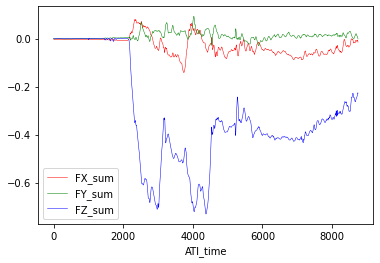

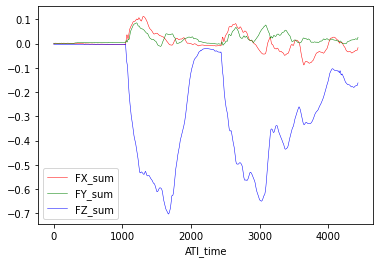

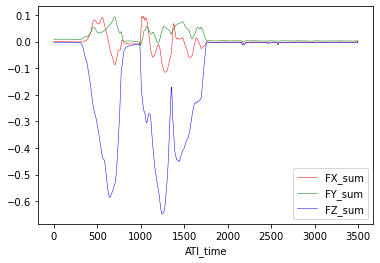

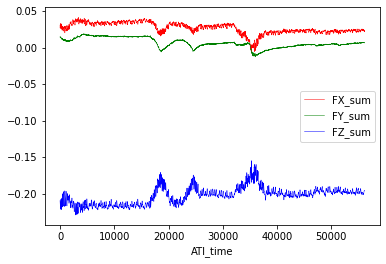

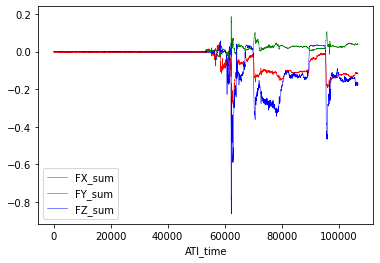

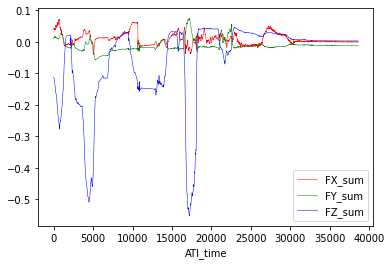

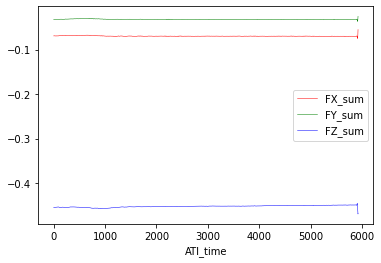

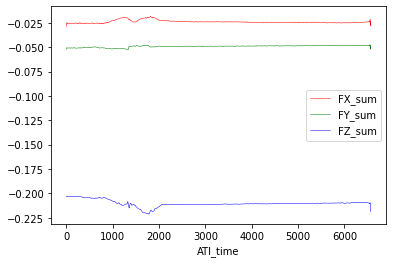

In [19]:
for trial_id in csv_dict.keys():
    ezplot(cropped_force_df.loc[trial_id])

## Resample to XROMM framerate

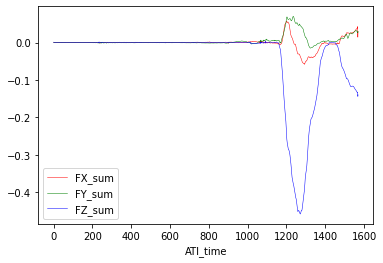

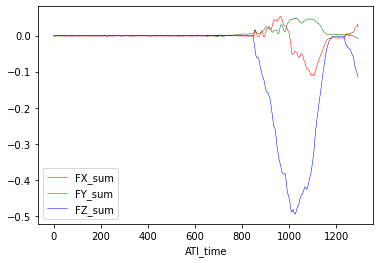

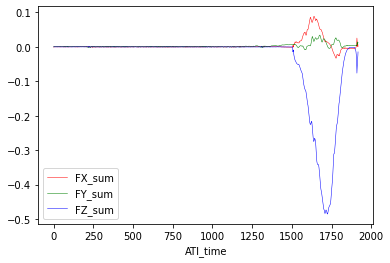

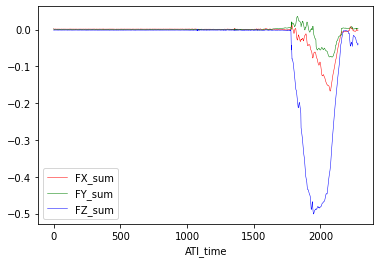

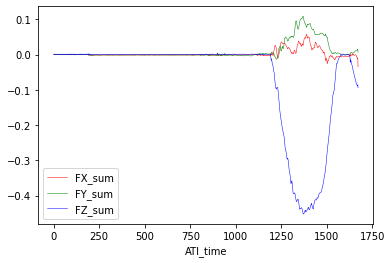

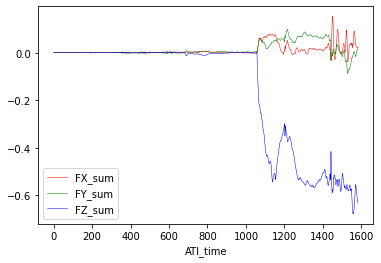

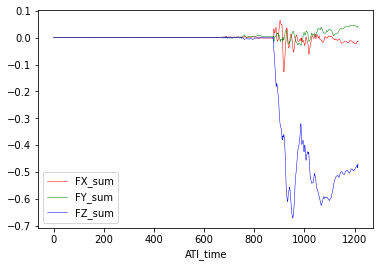

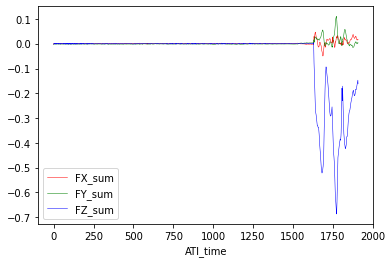

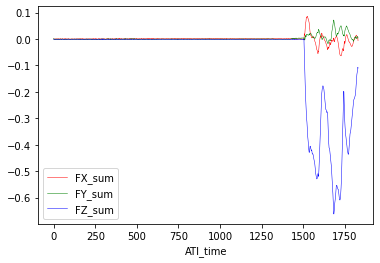

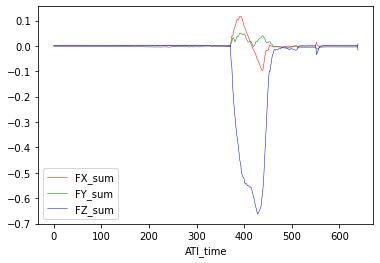

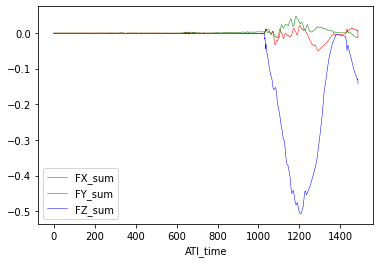

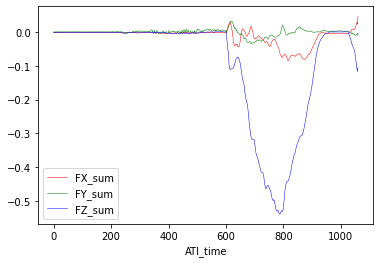

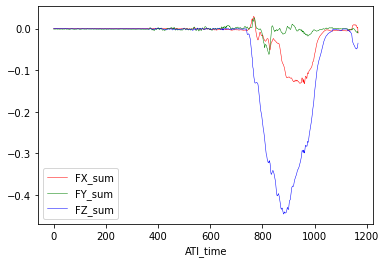

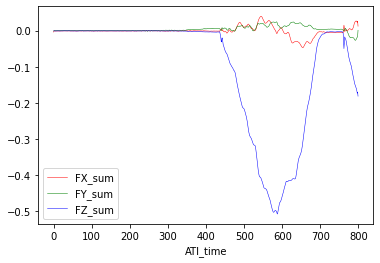

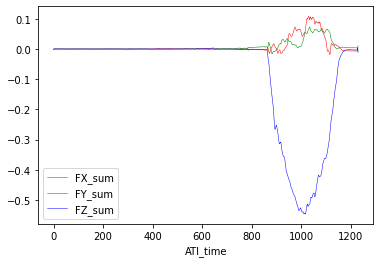

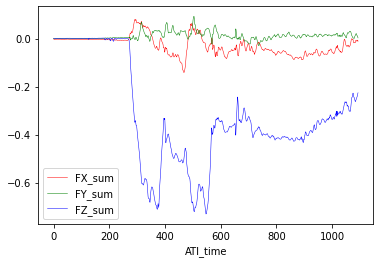

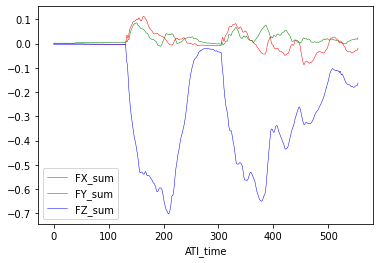

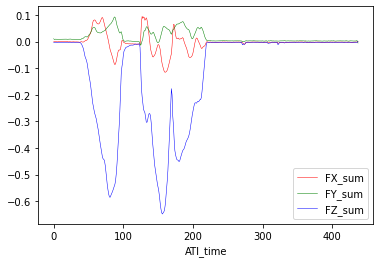

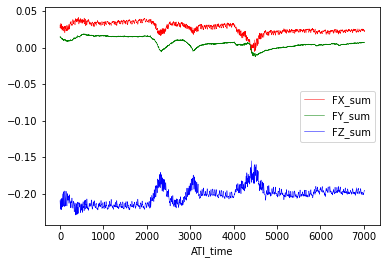

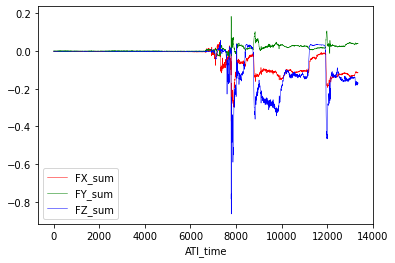

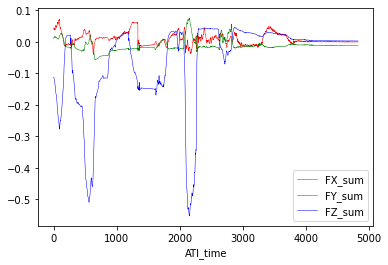

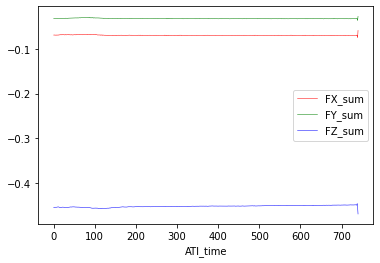

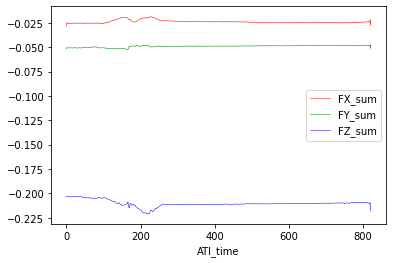

In [20]:
resampled_force_df = cropped_force_df.copy()
sort_order = list(csv_dict.keys())
resampled_force_df.index = resampled_force_df.index.set_levels(pd.to_timedelta(resampled_force_df.index.levels[1], unit='ms'), level=1)
resampled_force_df = resampled_force_df.groupby(level=0).apply(lambda x: x.reset_index(level=0,drop=True).resample(rule='8L').asfreq())
resampled_force_df.index = resampled_force_df.index.set_levels(pd.to_numeric(resampled_force_df.index.levels[1]), level=1)
resampled_force_df.index = resampled_force_df.index.set_levels(resampled_force_df.index.levels[1]/8000000, level=1)
resampled_force_df.index = resampled_force_df.index.set_levels(pd.to_numeric(resampled_force_df.index.levels[1],downcast='integer'), level=1)
resampled_force_df.reindex(sort_order, level=0)
for trial_id in csv_dict.keys():
    ezplot(resampled_force_df.loc[trial_id])

## Save out processed force data

In [21]:
out_dir = '/Users/phil/Desktop/rotoscoping/processed-forces-jul18-44hz'
export_force_df = resampled_force_df.loc[:,['FX_sum','FY_sum','FZ_sum']]
export_force_df.loc[:,['FX_sum','FZ_sum']] *= -1 #xromm scenes are LR flipped, reverse polarity of Z and X to get reaction force but leave ML (Y) as is
export_force_df.index.set_names(['trial','frame'], inplace=True)
export_force_df.columns = ['FX','FY','FZ']
for trial_id in csv_dict.keys():
    out_path = os.path.join(out_dir,trial_id+'.csv')
    ex_df = export_force_df.loc[trial_id]
    ex_df.to_csv(out_path)